In [1]:
import numpy as np
import idx2numpy
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.utils import shuffle

%matplotlib inline

In [2]:
def display(img):
    image_width = image_height = np.ceil(np.sqrt(img.shape[0])).astype(np.uint8)
    # (784) => (28,28)
    one_image = img.reshape(image_width,image_height)
    
    plt.axis('off')
    plt.imshow(one_image, cmap=cm.binary)
    
def dense_to_one_hot(labels_dense, num_classes):
    num_labels = labels_dense.shape[0]
    index_offset = np.arange(num_labels) * num_classes
    labels_one_hot = np.zeros((num_labels, num_classes))
    labels_one_hot.flat[index_offset + labels_dense.ravel()] = 1
    return labels_one_hot

In [3]:
X_train = idx2numpy.convert_from_file("../hw1_multi_lp/train-images.idx3-ubyte")
X_test = idx2numpy.convert_from_file("../hw1_multi_lp/t10k-images.idx3-ubyte")
y_train = idx2numpy.convert_from_file("../hw1_multi_lp/train-labels.idx1-ubyte")
y_test = idx2numpy.convert_from_file("../hw1_multi_lp/t10k-labels.idx1-ubyte")

X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)

labels_count = np.unique(y_train).shape[0]
y_train = dense_to_one_hot(y_train, labels_count)
y_test = dense_to_one_hot(y_test, labels_count)

In [4]:
X_train = X_train / 255.0
X_train = (X_train > 0.2).astype(np.int32)
X_test = X_test / 255.0
X_test = (X_test > 0.2).astype(np.int32)

In [60]:
class RBM():
    def _sigmoid(self, z):
        z = np.maximum(-15.0, z)
        z = np.minimum(15.0, z)
        return 1.0 / (1 + np.exp(-z))
    
    def cross_entropy(self, y_pred, y_true):
        eps = 1e-15
        y_pred = np.maximum(eps, y_pred)
        y_pred = np.minimum(1-eps, y_pred)
        return np.mean(-np.sum(np.log(y_pred) * y_true, axis=1))
        
        
    def gibbs_sampling(self, steps):
        pass
        
    
    def __init__(self, n_hidden, learning_rate, n_iter, gibbs_steps = 1, batch_size = 0,
                 layers = {'visible': 'bernoulli', 'hidden':  'bernoulli'}, verbose = False):
        self.n_visible = None
        self.n_hidden = n_hidden
        self.learning_rate = learning_rate
        self.n_iter = n_iter
        self.gibbs_steps = gibbs_steps
        self.verbose = verbose
        self.batch_size = batch_size
        self.visible_states = None
        self.visible_probs = None
        self.hidden_states = None
        self.hidden_probs = None
        self.loss_history = None
        self.layers = layers
        self.bias_visible = None
        self.bias_hidden = None
        
        
    def fit(self, X):
        self.loss_history = []
        if self.batch_size == 0:
            self.batch_size = X.shape[0] + 1
        self.n_visible = X.shape[1]
        # weights
        # self.weights = np.random.randn(self.n_visible, self.n_hidden)
        self.weights = np.random.normal(0, .1, (self.n_visible, self.n_hidden))
        # biases
        self.bias_visible = np.zeros((1, self.n_visible))
        self.bias_hidden = np.zeros((1, self.n_hidden))
        for epoch in range(self.n_iter):
            X = shuffle(X)
            # X_mini_batch = X[:self.batch_size]
            for i in range(len(X)/self.batch_size-1):
                X_mini_batch = X[i*self.batch_size:(i+1)*self.batch_size]
                self.visible_states = X_mini_batch.copy()
                for step in range(self.gibbs_steps):
                    self.run_on_visible(self.visible_states, learning = True) # POSITIVE CD PHASE
                    self.run_on_hidden(self.hidden_states, learning = True) # NEGATIVE CD PHASE
            
                # Weights updating.
                deltas_weights = []
                deltas_b_vis = []
                deltas_b_hid = []
                for idx, sample in enumerate(X_mini_batch):
                    pos_hid, _ = self.run_on_visible(sample.reshape(1,-1), learning = False)
                    _, neg_hid = self.run_on_visible(self.visible_states[idx].reshape(1,-1), learning = False)
                    deltas_weights.append(np.dot(sample.reshape(1,-1).T, pos_hid) -\
                                          np.dot(self.visible_states[idx].reshape(1,-1).T, neg_hid))
                    deltas_b_vis.append(sample.reshape(1,-1) - self.visible_states[idx].reshape(1,-1))
                    deltas_b_hid.append(pos_hid - neg_hid)
                self.weights += self.learning_rate * np.mean(deltas_weights, axis = 0)
                self.bias_visible += self.learning_rate * np.mean(deltas_b_vis, axis = 0) 
                self.bias_hidden += self.learning_rate * np.mean(deltas_b_hid, axis = 0)
                
            loss = self.cross_entropy(self.run_on_hidden(self.run_on_visible(X, learning = False), learning = False), X)
            self.loss_history.append(loss)
            if self.verbose and epoch % 10 == 0:
                print "Epoch: ", epoch," loss: ", loss
            
    def run_on_visible(self, X, learning = True):
        """
        given visible unit, getting a sample of hidden units
        """
        hidden_probs = self._sigmoid(self.bias_hidden + np.dot(X, self.weights))
        hidden_binaries = np.random.binomial(n=1, p=hidden_probs, size=hidden_probs.shape)
        if learning == True:
            self.hidden_states = hidden_binaries
            self.hidden_probs = hidden_probs
        return hidden_binaries, hidden_probs
    
    def run_on_hidden(self, X_hidden, learning = True):
        """
        given set of hidden units, trying to get some good visible units
        """
        visible_probs = self._sigmoid(self.bias_visible + np.dot(X_hidden, self.weights.T))
        visible_binaries = np.random.binomial(n=1, p=visible_probs, size=visible_probs.shape)
        if learning == True:
            self.visible_states = visible_binaries
            self.visible_probs = visible_probs
        return visible_binaries, visible_probs

# Fixed distribution

In [98]:
rbm_fixed = RBM(n_hidden = 3, learning_rate=0.25, n_iter=100, gibbs_steps = 2, batch_size = 20,
               layers = {'visible':'bernoulli',
                         'hidden':'bernoulli'})

# MNIST

In [61]:
rbm_nn = RBM(n_hidden=100, learning_rate=0.25, n_iter=100, gibbs_steps = 1, batch_size = 20, verbose = True,
            layers = {'visible': 'bernoulli',
                      'hidden':  'bernoulli'})

In [62]:
rbm_nn.fit(X_train[:1000])

Epoch:  0  loss:  2.18212655827
Epoch:  10  loss:  1.2624834668
Epoch:  20  loss:  1.0567531078
Epoch:  30  loss:  0.929387432065
Epoch:  40  loss:  0.856190540433
Epoch:  50  loss:  0.843982621825
Epoch:  60  loss:  0.781104722757
Epoch:  70  loss:  0.772793259005
Epoch:  80  loss:  0.723712741219
Epoch:  90  loss:  0.741733654947


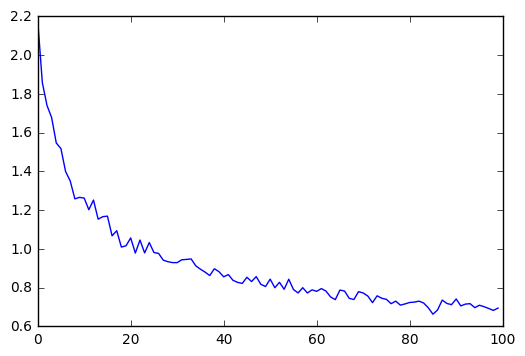

In [63]:
plt.plot(rbm_nn.loss_history)
# print "Accuracy: %.4f" % test_accuracy(np.argmax(testnn.predict(X_test), axis = 1), np.argmax(y_test, axis = 1))

In [97]:
def plot_neuron_acts(neurons, n, m, w=8, h=8):
    a1, a2 = float(n) / (n + m), float(m) / (n + m)
    f, axarr = plt.subplots(n, m, figsize=(2 * w * a2, 2 * h * a1))
    f.subplots_adjust(wspace=0, hspace=0)
    for i in range(n):
        for j in range(m):
            axarr[i, j].imshow(neurons[m * i + j], cmap='binary')
            axarr[i, j].tick_params(axis='both', which='both', bottom='off', top='off', right='off', left='off',
                                    labelbottom='off', labelleft='off')
            for spine in axarr[i, j].spines.values():
                spine.set_edgecolor('#ffffff')

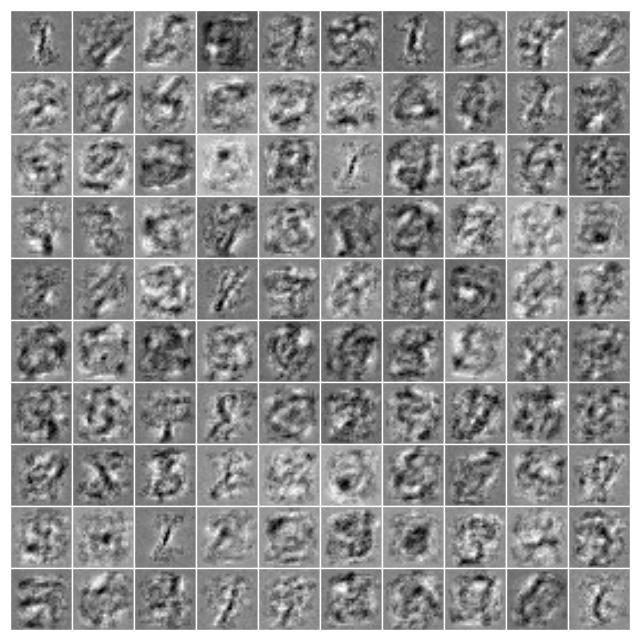

In [96]:
neurons = [rbm_nn.weights[:, i].reshape(28, 28) for i in range(rbm_nn.n_hidden)]
plot_neuron_acts(neurons, 10, 10)

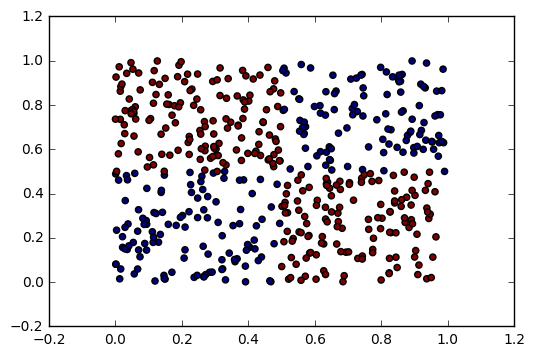

In [14]:
size_Train = 500
# XOR_original = np.array(np.random.randint(0,2, size = (size_Train,2)), dtype='float')
XOR_original = (np.random.random_sample((size_Train, 2)))
y_xor_train = np.array([int(np.round(n[0]) != np.round(n[1])) for n in XOR_original])
y_xor_train = np.array([[0,1] if n == 1 else [1,0] for n in y_xor_train])

size_test = 250
XOR_test = (np.random.random_sample((size_test, 2)))
y_xor_test = np.array([int(np.round(n[0]) != np.round(n[1])) for n in XOR_test])
y_xor_test = np.array([[0,1] if n == 1 else [1,0] for n in y_xor_test])

plt.scatter(XOR_original[:,0], XOR_original[:,1], c=np.argmax(y_xor_train, axis = 1))

In [15]:
rbm_xor_nn = RBM(n_hidden=4, learning_rate=0.1, n_iter=100, batch_size = 10)

In [28]:
rbm_xor_nn.fit(XOR_original)

# fitting
XOR_train_sampled = []
for idx, sample in enumerate(XOR_original):
    XOR_train_sampled.append(rbm_xor_nn.run_on_visible(sample.reshape(1,2), learning=False)[0])

XOR_train_sampled = np.array(XOR_train_sampled).reshape(size_Train, rbm_xor_nn.n_hidden)

# predicting
XOR_test_sampled = []
for idx, sample in enumerate(XOR_test):
    XOR_test_sampled.append(rbm_xor_nn.run_on_visible(sample.reshape(1,2), learning=False)[0])

XOR_test_sampled = np.array(XOR_test_sampled).reshape(size_test, rbm_xor_nn.n_hidden)

# true_pred = 0
# for idx, sample in enumerate(XOR_test_sampled):
#     if np.argmax(lr.predict_proba(sample.reshape(1,-1))) == np.argmax(y_xor_test[idx]):
#         true_pred += 1
# print "Accuracy: ", true_pred,'/',len(y_xor_test),'', 100*true_pred / float(len(y_xor_test)), '%'

# XOR

In [30]:
import nn

In [31]:
mlp_nn = nn.mlp_NN(batch_size=50, learning_rate=lambda x: 1.5, n_iter=1500,loss='cross-entropy',penalty='L1',C=1e-2,
               layers=[('Sigmoid', 4, True),
                       ('Softmax', 2, True)])

In [32]:
mlp_nn.fit(XOR_original, y_xor_train, init_weight=rbm_xor_nn.weights)

In [99]:
print 'Weights from RBM:'
print rbm_xor_nn.weights
print 'Weights after BP:'
print mlp_nn.weights[0]

Weights from RBM:
[[-0.03092701  0.03404561 -0.05501609 -0.10310746]
 [-0.02245064  0.04113549 -0.0589932  -0.06274949]]
Weights after BP:
[[ 4.47331748  7.37333298 -3.49070362 -1.879485  ]
 [ 4.47949006 -4.64751623  6.1395106   4.39299703]]


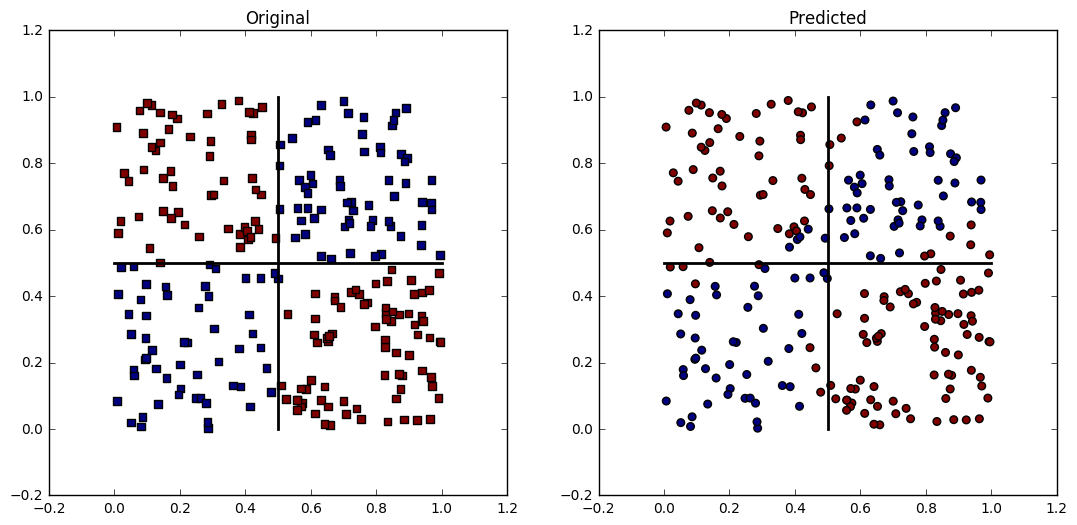

In [54]:
plt.subplots(1, 2, sharey=True, figsize=(13, 6))
plt.subplot(1,2,1),plt.scatter(XOR_test[:, 0], XOR_test[:, 1], c=np.argmax(y_xor_test, axis = 1), s=30,marker='s')
plt.plot([0.5,0.5],[0,1],lw=2,c='black'),plt.plot([0,1],[0.5,0.5],lw=2,c='black')
plt.title('Original')
plt.subplot(1,2,2),plt.scatter(XOR_test[:, 0], XOR_test[:, 1], c=np.argmax(mlp_nn.predict(XOR_test), axis = 1), s=30)
plt.plot([0.5,0.5],[0,1], lw=2,c='black'),plt.plot([0,1],[0.5,0.5], lw=2,c='black')
plt.title('Predicted')